# TensorFlow Exercise
The exercise purpose is to build a NN for classifying items types in the fashio-MNIST dataset using a MultiLayer Perceptron model. 

In [80]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.framework import ops
import math

In [68]:
# Init - some stuff we need
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

In [69]:
# Define function for loading data
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [70]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector. 
    mini_batch_size - size of the mini-batches, integer
    seed -- Control the "random" batches distribution 
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [71]:
def LoadData(path):
    # Load training/testing data
    train_data, train_labels = load_mnist(path, kind = 'train')
    test_data, test_labels = load_mnist(path, kind = 't10k')
    
    # Second order statistics for training/testing data
    print('Loading train/test data...')
    train_mean = np.mean(np.mean(train_data, axis=1, keepdims=True))
    train_std = np.std(np.std(train_data, axis=1, keepdims=True))
    print('train mean: %2.2f, train_std: %2.2f' % (train_mean, train_std))

    test_mean = np.mean(np.mean(test_data, axis=1, keepdims=True))
    test_std = np.std(np.std(test_data, axis=1, keepdims=True))
    print('test mean: %2.2f, test: %2.2f' % (test_mean, test_std))
    
    # Normalize input (according to TRAIN DATA ONLY!)
    train_data = (train_data - train_mean)/train_std
    test_data = (test_data - train_mean)/train_std
    
    # Convert labels to OneHot encoding
    num_classes = len(np.unique(train_labels))
    eye_mat = np.eye(num_classes)
    train_labels = eye_mat[train_labels].T
    test_labels = eye_mat[test_labels].T
    
    # return results
    return train_data.T, test_data.T, train_labels, test_labels, train_mean, train_std

In [72]:
# Load data after normalization
X_train, X_test, Y_train, Y_test, X_train_mean, X_train_std = LoadData(r'data\fashion')

Loading train/test data...
train mean: 72.94, train_std: 20.04
test mean: 73.15, test: 19.90


In [88]:
Y_train.shape

(10, 60000)

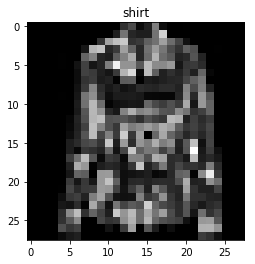

In [73]:
# Some plotting of the images to verify
sampleIdx = 118
data = np.reshape(X_train[:,sampleIdx].reshape(784,1), (28, 28))
data = data*X_train_std + X_train_mean # Revert normalization
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
plt.title('%s' % (labels[np.argwhere(Y_train[:,sampleIdx] == 1 )[0][0]]))
plt.show()

In [74]:
def initialize_parameters(nl, seed):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes (example) are:
    W1 : [32, 784] b1 : [32, 1]
    W2 : [16, 32] b2 : [16, 1]
    W3 : [10, 16] b3 : [10, 1]
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    tf.set_random_seed(seed)                   # so that your "random" numbers match ours
    parameters = dict()
    initializer = tf.contrib.layers.xavier_initializer(seed)
    for i in range(0, len(nl)-1):
        var = "W"+str(i+1)
        parameters[var] = tf.get_variable(var, [nl[i+1], nl[i]], initializer = initializer)
        var = "b"+str(i+1)
        parameters[var] = tf.get_variable(var, [nl[i+1], 1], initializer = tf.zeros_initializer())
    return parameters

In [ ]:
def forward_propagation(X, parameters, train=True):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    nl = len(parameters)/2 # number of layers
    
    A = X # Initial layer
    for l in range(0,int(nl)):
        W, b = parameters['W'+str(l+1)],parameters['b'+str(l+1)]
        Z = tf.add( tf.matmul(W,A), b)
        if train == True:
            Z = tf.nn.dropout(Z, rate=0.05)  # DROP-OUT here
        A = tf.nn.leaky_relu(Z)

    return Z

In [76]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 28 * 28 = 784)
    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """
    X = tf.placeholder(tf.float32, shape=(n_x, None), name = "X")
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name = "Y")
    
    return X, Y

In [77]:
def compute_cost(Z, Y):
    """ 
    Computes the cost
    
    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits, labels = tf.transpose(Z), tf.transpose(Y)    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    return cost

In [113]:
def model(X_train, Y_train, X_test, Y_test, nl = [784, 32, 16, 10], learning_rate = 0.001,
          num_epochs = 10, minibatch_size = 32, print_cost = True, seed = 1):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 784, number of training examples = 60K)
    Y_train -- test set, of shape (output size = 10, number of training examples = 10K)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(seed)                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders( n_x, n_y )

    # Initialize parameters
    parameters = initialize_parameters(nl, seed)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(tf.cast(X_train, tf.float32), parameters, train=True)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y_train)
    
    # Backpropagation via tensorflow optimizer with AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
 
                # Cost 
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        
        Z = forward_propagation(tf.cast(X_test, tf.float32), parameters, train=False)
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.455941
Cost after epoch 1: 0.272770
Cost after epoch 2: 0.232143
Cost after epoch 3: 0.214416
Cost after epoch 4: 0.203681
Cost after epoch 5: 0.196704
Cost after epoch 6: 0.191493
Cost after epoch 7: 0.187494
Cost after epoch 8: 0.184271
Cost after epoch 9: 0.181622


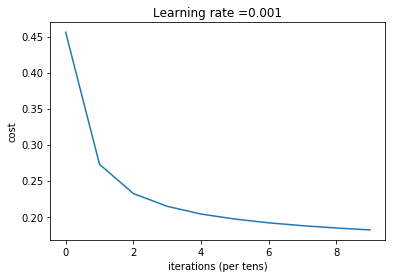

Parameters have been trained!
Train Accuracy: 0.9346333
Test Accuracy: 0.8649


In [114]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [ ]:
# Test accuracy 0.8623 (dropout 0.2)
# Test accuracy 0.8628 (dropout 0.1)
# Test accuracy 0.8609 (dropout 0.1, 30 epochs)
Train Accuracy: 0.9346333
Test Accuracy: 0.8649